# Python example using Spark SQL over Cloudant as a source

This sample notebook is written in Python and expects the Python 2.7.5 runtime. Make sure the kernel is started and you are connect to it when executing this notebook.

The data source for this example can be found at: http://examples.cloudant.com/crimes/

Replicate the database into your own Cloudant account before you execute this script.

In [245]:
# Import Python stuff
import pprint
from collections import Counter

In [246]:
    # Import PySpark stuff
    from pyspark.sql import *
    from pyspark.sql.functions import udf, asc, desc
    from pyspark import SparkContext, SparkConf
    from pyspark.sql.types import IntegerType

# 1. Work with the Spark Context

A Spark Context handle `sc` is available with every notebook create in the Spark Service. Use it to understand the Spark version used, the environment settings, and create a Spark SQL Context object off of it.

In [247]:
sc.version

u'1.4.1'

In [248]:
# sc is an existing SparkContext.
sqlContext = SQLContext(sc)

## 2. Work with a Cloudant database

A Dataframe object can be created directly from a Cloudant database. To configure the database as source, pass these options:

1 - package name that provides the classes (like `CloudantDataSource`) implemented in the connector to extend `BaseRelation`. For the Cloudant Spark connector this will be `com.cloudant.spark`

2 - `cloudant.host` parameter to pass the Cloudant account name

3 - `cloudant.user` parameter to pass the Cloudant user name

4 - `cloudant.password` parameter to pass the Cloudant account password

In [250]:
cloudantdata = sqlContext.read.format("com.cloudant.spark").\
option("cloudant.host","examples.cloudant.com").\
option("cloudant.username","examples").\
option("cloudant.password","xxxxx").\
load("crimes")

## 3. Work with a Dataframe

At this point all transformations and functions should behave as specified with Spark SQL. (http://spark.apache.org/sql/)

There are, however, a number of things the Cloudant Spark connector does not support yet, or things that are simply not working. For that reason we call this connector a **BETA** release and are only gradually improving it towards GA. 

Please direct your any change requests at [support@cloudant.com](mailto:support@cloudant.com)

In [251]:
cloudantdata.printSchema()

root
 |-- _id: string (nullable = true)
 |-- _rev: string (nullable = true)
 |-- geometry: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- properties: struct (nullable = true)
 |    |-- compnos: string (nullable = true)
 |    |-- domestic: boolean (nullable = true)
 |    |-- fromdate: long (nullable = true)
 |    |-- main_crimecode: string (nullable = true)
 |    |-- naturecode: string (nullable = true)
 |    |-- reptdistrict: string (nullable = true)
 |    |-- shooting: boolean (nullable = true)
 |    |-- source: string (nullable = true)
 |-- type: string (nullable = true)



In [252]:
cloudantdata.count()

271

In [253]:
cloudantdata.select("properties.naturecode").show()

+----------+
|naturecode|
+----------+
|    DISTRB|
|       EDP|
|    ARREST|
|        AB|
|      CD14|
|    UNKEMS|
|      REQP|
|       EDP|
|       MVA|
|     IVPER|
|      NIDV|
|        AB|
|    IVPREM|
|     IVPER|
|     IVPER|
|       MVA|
|      CD11|
|    LARCEN|
|       MVA|
|    ARREST|
+----------+



**Here we filter only those documents where the naturecode is crime is a disturbance with naturecode DISTRB**

In [254]:
disturbDf = cloudantdata.filter("properties.naturecode = 'DISTRB'")
disturbDf.show()

+--------------------+--------------------+--------------------+--------------------+-------+
|                 _id|                _rev|            geometry|          properties|   type|
+--------------------+--------------------+--------------------+--------------------+-------+
|79f14b64c57461584...|1-d9518df5c255e4b...|[List(-71.0598744...|[142035012,true,1...|Feature|
|79f14b64c57461584...|1-798ef404b141dfb...|[List(-71.0554045...|[142035053,false,...|Feature|
|79f14b64c57461584...|1-08cd46894f9c579...|[List(-71.1317963...|[142035113,false,...|Feature|
|79f14b64c57461584...|1-be4512491803441...|[List(-71.1331290...|[142035116,false,...|Feature|
|79f14b64c57461584...|1-2e3e1fe35278b5d...|[List(-71.0784045...|[142035162,false,...|Feature|
|79f14b64c57461584...|1-e03133da93c2644...|[List(-71.0824845...|[142035211,false,...|Feature|
|79f14b64c57461584...|1-4c21d07bfb9f45a...|[List(-71.1013666...|[142035316,false,...|Feature|
+--------------------+--------------------+-----------------

**Finally we write the disturbance crimes back to another Cloudant database 'crimes_filtered'**

In [255]:
disturbDf.select("properties").write.format("com.cloudant.spark").\
option("cloudant.host","kache.cloudant.com").\
option("cloudant.username","kache").\
option("cloudant.password","xxxxx").\
save("crimes_filtered")

## 4. Visualization

In [256]:
reducedValue = cloudantdata.groupBy("properties.naturecode").count()
reducedValue.printSchema()


root
 |-- naturecode: string (nullable = true)
 |-- count: long (nullable = false)



I'm converting a Apache Spark Data Frame to a Panda Data Frame first. Matplotlib simply seems to have better support for Pandas today.

Let's also sort the DF by `count` first and `naturecode` second to produce a sorted graph.

In [259]:
import pandas as pd
pandaDf = reducedValue.orderBy(desc("count"), asc("naturecode")).toPandas()
print(pandaDf)

   naturecode  count
0       IVPER     40
1      LARCEN     27
2         MVA     25
3      ARREST     19
4      IVPREM     13
5        DVIP     12
6        NIDV     12
7          AB     11
8          BE     11
9        PROP     11
10       IVMV     10
11       VAND      9
12     VIORDR      9
13     DISTRB      7
14        EDP      4
15     INVEST      4
16     ROBBER      4
17         SS      4
18      FIGHT      3
19     LANTEN      3
20       None      2
21      ALARM      2
22     CARDIA      2
23       CD11      2
24     HOMINV      2
25     MISSIN      2
26     PERGUN      2
27     POISON      2
28       REQP      2
29        UNK      2
30        AOD      1
31     ARMROB      1
32       CD14      1
33       CD35      1
34        CD9      1
35     INJOFF      1
36       MISC      1
37     PKNIFE      1
38     PRSCRM      1
39      REQEP      1
40      SHOTS      1
41         TS      1
42     UNKEMS      1


In [260]:
# This is needed to actually see the plots
%matplotlib inline

# Additional imports frm matplotlib
import matplotlib.pyplot as plt

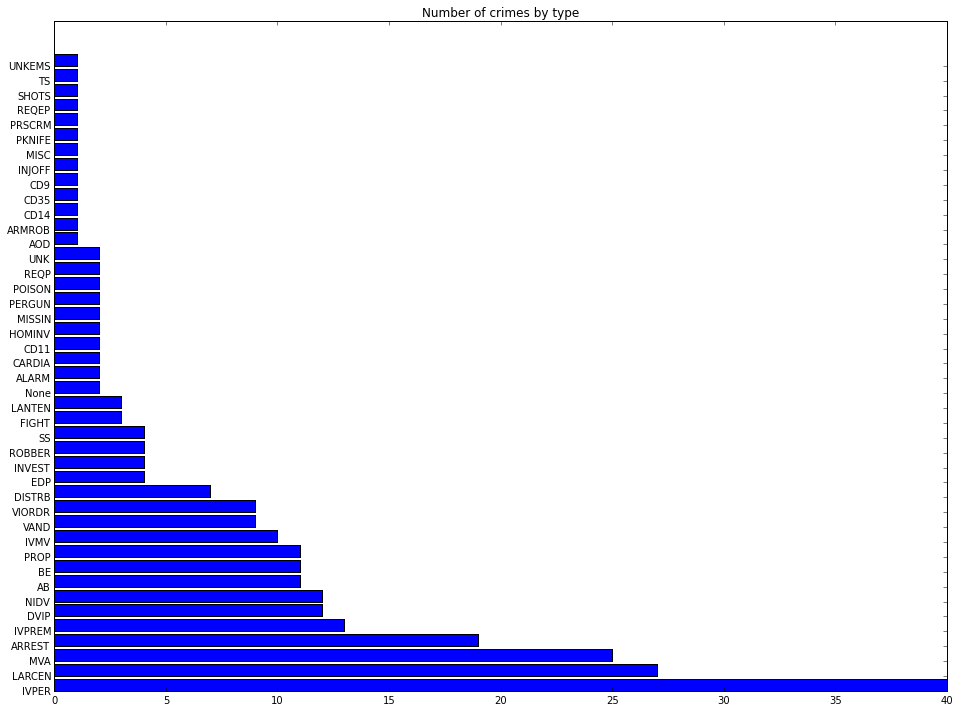

In [261]:
# The data
values = pandaDf['count']
labels = pandaDf['naturecode']

# The format
plt.gcf().set_size_inches(16, 12, forward=True)
plt.title('Number of crimes by type')

# Barh is a horizontal bar chart with values (x axis) and labels (y axis)
plt.barh(range(len(values)), values)
plt.yticks(range(len(values)), labels)

# Print the plot
plt.show()
